# Imports and Ignore Warnings

In [3]:
import warnings

# Disable all warnings
warnings.filterwarnings("ignore")

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

# Load dataset (MNIST for simplicity)

In [5]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# Define Parameters and custom loss function

In [6]:
# Parameters
latent_dim = 2  # Dimensionality of the latent space
input_shape = (28, 28, 1)


In [7]:
# Custom loss functions
def vae_reconstruction_loss(y_true, y_pred):
    reconstruction_loss_factor = 1000
    reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(y_true - y_pred), axis=[1, 2]))
    return reconstruction_loss_factor * reconstruction_loss

def kl_loss(encoder_mu, encoder_log_variance):
    kl_loss_value = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + encoder_log_variance - tf.square(encoder_mu) - tf.exp(encoder_log_variance), axis=1))
    return kl_loss_value

def vae_loss(y_true, y_pred, encoder_mu, encoder_log_variance):
    reconstruction_loss = vae_reconstruction_loss(y_true, y_pred)
    kl_loss_value = kl_loss(encoder_mu, encoder_log_variance)
    return reconstruction_loss + kl_loss_value

# Define Encoder and Decoder

In [8]:
# Define the Encoder
inputs = layers.Input(shape=input_shape)
x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
x = layers.MaxPooling2D(2, padding='same')(x)
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2, padding='same')(x)
x = layers.Flatten()(x)
mu_log_var = layers.Dense(latent_dim + latent_dim)(x)  # z_mean and z_log_var
encoder = models.Model(inputs, mu_log_var, name="encoder")

I0000 00:00:1727150073.517969     583 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727150073.682252     583 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727150073.682314     583 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727150073.687453     583 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727150073.687518     583 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [9]:
# Define the Decoder
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation='relu')(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation='relu', padding='same')(x)
x = layers.UpSampling2D(2)(x)
x = layers.Conv2DTranspose(32, 3, activation='relu', padding='same')(x)
x = layers.UpSampling2D(2)(x)
outputs = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)
decoder = models.Model(latent_inputs, outputs, name="decoder")

# Define VAE and Train It

In [11]:
# VAE Call Method
class VAE(models.Model):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        mu_log_var = self.encoder(inputs)
        encoder_mu, encoder_log_variance = tf.split(mu_log_var, num_or_size_splits=2, axis=1)

        # Reparameterization trick
        epsilon = tf.random.normal(tf.shape(encoder_log_variance))
        z = encoder_mu + tf.exp(0.5 * encoder_log_variance) * epsilon
        
        # Decode
        outputs = self.decoder(z)

        # Add loss
        self.add_loss(vae_loss(inputs, outputs, encoder_mu, encoder_log_variance))
        return outputs

In [12]:
# Instantiate and compile the VAE model
vae = VAE(encoder, decoder)
vae.compile(optimizer='adam')

In [13]:
# Train the VAE
vae.fit(x_train, x_train, epochs=10, batch_size=128, validation_data=(x_test, x_test))

Epoch 1/10


I0000 00:00:1727150151.468546    2504 service.cc:146] XLA service 0x7fc37000f270 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727150151.468595    2504 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-09-24 09:25:51.523952: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-24 09:25:51.738302: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 27/469 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 135162.5625

I0000 00:00:1727150156.041220    2504 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 83783.8984 - val_loss: 39142.0547
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 37877.0898 - val_loss: 35990.5859
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 35518.3086 - val_loss: 34670.2539
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 34503.6289 - val_loss: 34115.0469
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 33732.1758 - val_loss: 33749.2500
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 33376.5195 - val_loss: 33292.3828
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 33101.8789 - val_loss: 33266.1016
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 32773.5625 - val_loss: 32930.0781
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 32580.3223 - val_loss: 32748.4023
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 32430.4355 - val_loss: 32557.3730


# Vizualising Latent Space

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


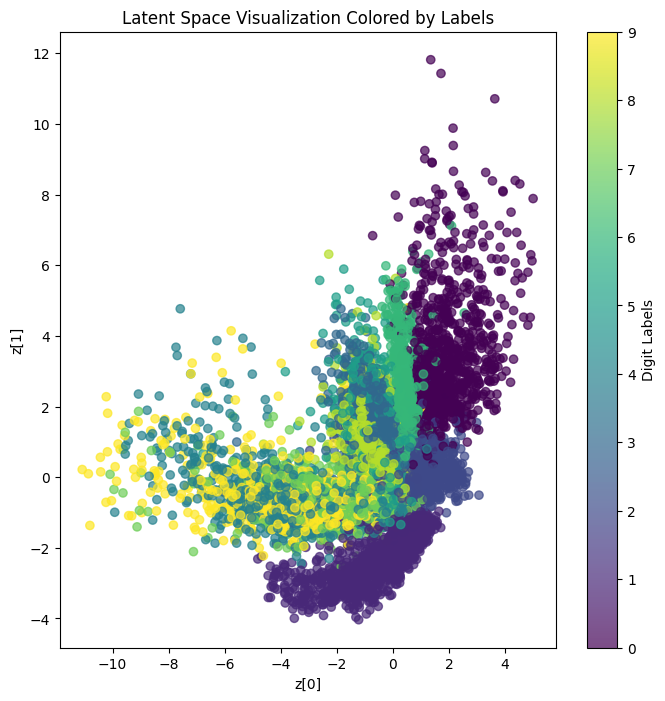

In [16]:
import matplotlib.pyplot as plt

# Load dataset with labels
(_, y_train), (_, y_test) = tf.keras.datasets.mnist.load_data()

# Encode the test images into the latent space
mu_log_var = encoder.predict(x_test)
z_mean, _ = np.split(mu_log_var, 2, axis=1)

# Plot the latent space with colors based on the true labels
plt.figure(figsize=(8, 8))
scatter = plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Digit Labels')
plt.title('Latent Space Visualization Colored by Labels')
plt.xlabel('z[0]')
plt.ylabel('z[1]')
plt.show()


# Beta VAE

to convert it to beta VAE, we just have to modify the loss function to have a beta value

In [17]:
# Introduce a beta parameter
beta = 4.0  # This is the value of β; you can experiment with different values

# Custom loss functions
def vae_reconstruction_loss(y_true, y_pred):
    reconstruction_loss_factor = 1000
    reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(y_true - y_pred), axis=[1, 2]))
    return reconstruction_loss_factor * reconstruction_loss

def kl_loss(encoder_mu, encoder_log_variance):
    kl_loss_value = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + encoder_log_variance - tf.square(encoder_mu) - tf.exp(encoder_log_variance), axis=1))
    return kl_loss_value

def vae_loss(y_true, y_pred, encoder_mu, encoder_log_variance):
    reconstruction_loss = vae_reconstruction_loss(y_true, y_pred)
    kl_loss_value = kl_loss(encoder_mu, encoder_log_variance)
    return reconstruction_loss + beta * kl_loss_value  # Scale KL divergence with beta
